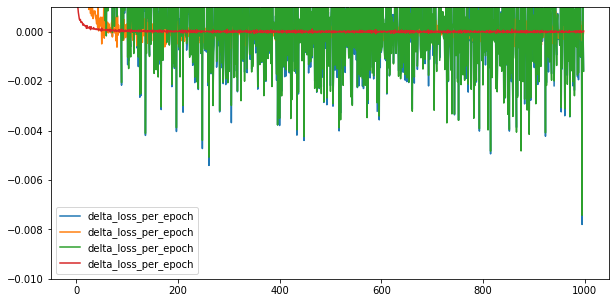

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

history_file = 'models/triad_1000e/histry.h5'
hist = pd.read_hdf(history_file)
hist.head()

loss = ['loss', 'dense_1_loss', 'dense_3_loss', 'dense_5_loss']
val_loss = ['val_loss', 'val_dense_1_loss', 'val_dense_3_loss', 'val_dense_5_loss']

loss = hist[loss].values
val_loss = hist[val_loss].values
delta_loss_per_epoch = -1.0*np.diff(loss, axis=0)
delta_val_loss_per_epoch = -1.0*np.diff(val_loss, axis=0)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
# ax.plot(loss, label='loss')
# ax.plot(val_loss, label='val_loss')
ax.plot(delta_loss_per_epoch, label='delta_loss_per_epoch')
# ax.plot(delta_val_loss_per_epoch, label='delta_val_loss_per_epoch')
ax.legend()
ax.set_ylim([-0.01, 0.001])
plt.show()

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import uproot

In [24]:
def GetData(filename, treename="timing"):
    '''
    Returns TFile as a pandas dataframe
    '''
    file = uproot.open(filename)
    print(file.keys())
    tree = file[treename]
    npdf = tree.arrays(library="np")
    df =  pd.DataFrame(npdf, columns=npdf.keys())
    return df

def GetTraces(values,traceLength=300):
    traces = np.zeros((values.shape[0], traceLength))
    for i in range(values.shape[0]):
        trace = np.array(values[i]).reshape(traceLength, 1)
        traces[i][:] = trace[:, 0]
    return traces

def GetPhases(phases):
    phase = np.zeros((phases.shape[0], 1))
    for i in range(phases.shape[0]):
        if phases[i] > 0:
            phase[i] = phases[i]
        else:
            phase[i] = 0.0
    return phase

def NormalizeTraces(traces):
    ''' 
    Normailze traces to have a max of 1 and a min of 0
    '''
    
    for i in range(traces.shape[0]):
        min_before_peak = np.min(traces[i][:100])
        traces[i][:] = traces[i][:] - min_before_peak
        
    return traces / np.max(traces, axis=1)[:, None]

import re

dir = 'data/lyso950V/'
files = ['pileup10600ps.root']

traces = []
phases = []
ifPile = []
qdcs = []
amps = []
for f in files:
    fname = dir+f
    tree = 'data'
    traceBranch = "traceone"
    traceLength = 250
    phase = float(re.sub('\D','',f))/1000
    print(phase)
    print(fname)
    pdf = GetData(fname,tree)
    print(pdf.size)
    pdf = pdf[pdf[traceBranch].apply(lambda x: x.shape[0] == traceLength)].reset_index(drop=True)
    print(pdf.size)
    qdcs.append(GetPhases(pdf["qdcone"].values))
    tt = GetTraces(pdf[traceBranch].values,traceLength)
    traces.append(tt)
    phases.append(np.full((len(tt),1),phase))
    ifPile.append(np.full((len(tt),1),phase>0))
    amps.append(np.full((len(tt),1),phase>0).astype(float))


10.6
data/lyso950V/pileup10600ps.root
['data;1']


336315
335615


In [25]:
from itertools import chain
traces = list(chain.from_iterable(traces))
phases = list(chain.from_iterable(phases))
ifPile = list(chain.from_iterable(ifPile))
qdcs = list(chain.from_iterable(qdcs))
amps = list(chain.from_iterable(amps))
traces = NormalizeTraces(np.array(traces))
phases = np.array(phases)
ifPile = np.array(ifPile)
amps = np.array(amps)
qdcs = np.array(qdcs)
# amps = ifPile.astype(np.float)
print('Formatted Data')
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y, train_q, test_q, train_ifPile, test_ifPile, train_amps, test_amps = train_test_split(traces,phases,qdcs,ifPile,amps,test_size=0.9)

Formatted Data


In [29]:
train_amps.shape

(958, 1)

In [41]:
NUMEPOCHS = 50
PHASEMAX = 100
PERCENTPILEUP = 0.5
NUMTRAINING = 20000
ModelOutputName = 'triad_1000e'
AUGMENTATION = 0
TRACELENGTH = 250

from tensorflow.keras.callbacks import EarlyStopping
class EarlyStoppingWithUntrainableLayers(EarlyStopping):
    def __init__(self, monitor='loss_name', min_delta=0, patience=0, verbose=0, mode='auto', 
                 baseline=None, restore_best_weights=False, layers_to_freeze=[], **kwargs):
        super().__init__(monitor=monitor, min_delta=min_delta, patience=patience, 
                         verbose=verbose, mode=mode, baseline=baseline, 
                         restore_best_weights=restore_best_weights, **kwargs)
        self.monitor = monitor
        self.layers_to_freeze = layers_to_freeze
        
    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        if self.stopped_epoch is not None:
            self._set_layers_untrainable()

    def on_train_end(self, logs=None):
        super().on_train_end(logs)
        if self.restore_best_weights and self.stopped_epoch is None:
            self._set_layers_untrainable()

    def _set_layers_untrainable(self):
        print(f'{self.monitor} stopped at epoch {self.stopped_epoch}')
        for layer in self.layers_to_freeze:
            layer.trainable = False


def TriadNet():
    defSize = TRACELENGTH-4*AUGMENTATION

    input = layers.Input(shape=(defSize,1))

    # Pileup Net
    pileupconv1 = layers.Conv1D(kernel_size=10, filters=64, activation='tanh', name='pileupconv1')(input)
    pileup_conv1_dropout = layers.Dropout(0.2, name='pileupconv1_dropout')(pileupconv1)
    # pileupmax1 = layers.MaxPooling1D(pool_size=1)(pileupconv1)
    pileupconv3 = layers.Conv1D(kernel_size=1, filters=64, activation='relu', name ='pileupconv3')(pileup_conv1_dropout)
    pileup_conv3_dropout = layers.Dropout(0.2, name='pileupconv3_dropout')(pileupconv3)
    # pileupmax3 = layers.MaxPooling1D(pool_size=1)(pileupconv3)
    pileupflat1 = layers.Flatten(name='pileupflat1')(pileup_conv3_dropout)
    
    
    pileupdense2 = layers.Dense(64, activation='relu', name='pileupdense2')(pileupflat1)
    pileupoutput = layers.Dense(1, activation='sigmoid', name='pileupoutput')(pileupdense2)

    # Phase Net
    phaseconv1 = layers.Conv1D(kernel_size=10, filters=64, activation='tanh', name='phaseconv1')(input)
    phase_conv1_dropout = layers.Dropout(0.2, name='phase_conv1_dropout')(phaseconv1)
    # phasemax1 = layers.MaxPooling1D(pool_size=1)(phaseconv1)
    phaseconv3 = layers.Conv1D(kernel_size=1, filters=64, activation='relu', name='phaseconv3')(phase_conv1_dropout)
    phase_conv3_dropout = layers.Dropout(0.2, name='phase_conv3_dropout')(phaseconv3)
    # phasemax3 = layers.MaxPooling1D(pool_size=1)(phaseconv3)
    phaseconv4 = layers.Conv1D(kernel_size=2, filters=64, activation='relu', padding='same', name='phaseconv4')(phase_conv3_dropout)
    phase_conv4_dropout = layers.Dropout(0.2, name='phase_conv4_dropout')(phaseconv4)
    # phasemax4 = layers.MaxPooling1D(pool_size=10)(phaseconv4)
    
    phaseflat1 = layers.Flatten(name='phaseflat1')(phase_conv4_dropout)
    phasedense2 = layers.Dense(128, activation='relu', name='phasedense2')(phaseflat1)
    phaseoutput = layers.Dense(1, activation='linear', name='phaseoutput')(phasedense2)

    # Amp Net
    ampconv1 = layers.Conv1D(kernel_size=10, filters=64, activation='tanh', name='ampconv1')(input)
    amp_conv1_dropout = layers.Dropout(0.2, name='amp_conv1_dropout')(ampconv1)
    # ampmax1 = layers.MaxPooling1D(pool_size=1)(ampconv1)
    ampconv3 = layers.Conv1D(kernel_size=1, filters=64, activation='relu', name='ampconv3')(amp_conv1_dropout)
    amp_conv3_dropout = layers.Dropout(0.2, name='amp_conv3_dropout')(ampconv3)
    # ampmax3 = layers.MaxPooling1D(pool_size=1)(ampconv3)
    ampconv4 = layers.Conv1D(kernel_size=2, filters=64, activation='relu', padding='same', name='ampconv4')(amp_conv3_dropout)
    amp_conv4_dropout = layers.Dropout(0.2, name='amp_conv4_dropout')(ampconv4)
    # ampmax4 = layers.MaxPooling1D(pool_size=10)(ampconv4)
    
    ampflat1 = layers.Flatten(name='ampflat1')(amp_conv4_dropout)
    ampdense2 = layers.Dense(128, activation='relu', name='ampdense2')(ampflat1)
    ampoutput = layers.Dense(1, activation='linear', name='ampoutput')(ampdense2)
    

    model = models.Model(inputs=input, outputs=[pileupoutput,phaseoutput,ampoutput])
    model.summary()
    
    return model

In [42]:
triad = TriadNet()
phase_layers = [layer for layer in triad.layers if 'phase' in layer.name]
pileup_layers = [layer for layer in triad.layers if 'pileup' in layer.name]
amp_layers = [layer for layer in triad.layers if 'amp' in layer.name]

min_delta = 0.005
patience = 3
early_stopping_all =tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=min_delta,
    patience=patience,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

early_stopping_pileup = EarlyStoppingWithUntrainableLayers(
    monitor='val_pileupoutput_loss',
    min_delta=min_delta,
    patience=patience,
    verbose=1,
    restore_best_weights=True,
    layers_to_freeze=pileup_layers
)

early_stopping_phase = EarlyStoppingWithUntrainableLayers(
    monitor='val_phaseoutput_loss',
    min_delta=min_delta,
    patience=patience,
    verbose=1,
    restore_best_weights=True,
    layers_to_freeze=phase_layers
)

early_stopping_amp = EarlyStoppingWithUntrainableLayers(
    monitor='val_ampoutput_loss',
    min_delta=min_delta,
    patience=patience,
    verbose=1,
    restore_best_weights=True,
    layers_to_freeze=amp_layers
)


triad.compile(optimizer='adam', loss=['bce','mse','mse'], metrics='accuracy')
history = triad.fit(train_x, [train_ifPile,train_y,train_amps], epochs=20, batch_size=256, validation_split=0.2, verbose=2, callbacks=[early_stopping_all,early_stopping_pileup,early_stopping_phase,early_stopping_amp])


# triad.compile(optimizer='adam', loss=['bce','mse','mse'], metrics='accuracy')
# get layer names
# layer_names = [layer.name for layer in triad.layers]
# print(layer_names)



Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 250, 1)]             0         []                            
                                                                                                  
 phaseconv1 (Conv1D)         (None, 241, 64)              704       ['input_14[0][0]']            
                                                                                                  
 ampconv1 (Conv1D)           (None, 241, 64)              704       ['input_14[0][0]']            
                                                                                                  
 phase_conv1_dropout (Dropo  (None, 241, 64)              0         ['phaseconv1[0][0]']          
 ut)                                                                                       